# Basic: Recovering the 12-6 Lennard-Jones Potential

This tutorial reveals the basics of the potential-matching forcefield optimization framework.  Our system will contain two point particles, and we will attempt to recover a simple 12-6 Lennard-Jones interaction between them.

In [1]:
from nanoparticle_optimization.forcefield import Mie, Parameter

sigma_target = Parameter(value=5.0, fixed=True)
epsilon_target = Parameter(value=5.0, fixed=True)
n_target = Parameter(value=12.0, fixed=True)
m_target = Parameter(value=6.0, fixed=True)

lj_12_6 = Mie(sigma=sigma_target, epsilon=epsilon_target, n=n_target, m=m_target)

Potential functions feature many functional forms.  These functional forms can be defined as subclasses of the  `Forcefield` (abstract) class, where the parameters required for instantiation are defined as well as a function for evaluating the potential energy as a function of inter-particle separation.  One of the predefined `Forcefield` subclasses is the `Mie` class, which defines the mie potential.  We can use this subclass, setting the exponents `n` and `m` to 12 and 6 respectively, to define a 12-6 Lennard-Jones potential.

Parameters passed as arguments during `Forcefield` instantiation are instances of the `Parameter` class.  Each parameter must be provided with a `value`, as well as an `upper` and `lower` bound to be used during optimization.  Alternatively, a parameter may be set as `fixed`, whereby these `upper` and `lower` bounds are not required as the parameter will not be altered during optimization.  Here, since we are defining our target forcefield, as opposed to one we want to optimize, we will set each parameter to be `fixed`.  The values we provide here are those we hope to recover during the optimization.

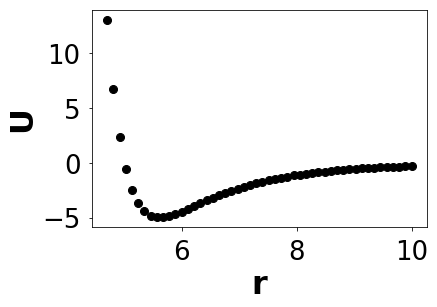

In [14]:
import numpy as np

from nanoparticle_optimization.target import Target

separations = np.linspace(4.7, 10.0, 50)
potential = np.array([lj_12_6.calc_potential(r) for r in separations])
target = Target(separations=separations, potential=potential)

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(separations, potential, linestyle='None', marker='o', color='black')
plt.xlabel('r')
plt.ylabel('U')

The `Target` class is used to define a set of target data to be used during an optimization, which takes as arguments a list of `separations` and `potential` values.  These two lists must have the same length, where each value in `potential` corresponds to the interaction potential at a corresponding inter-particle separation in `separation`.  For this tutorial, we define our target data by generating a set of 50 points along the 12-6 LJ potential curve.

In [15]:
import mbuild as mb

from nanoparticle_optimization.system import System

point_particle = mb.Compound(pos=np.zeros(3))
system = System(point_particle)

The `System` class defines a system of two mBuild `Compounds`.  This class contains functions for calculating the interaction potential between the two `Compounds`, using a provided `Forcefield`, that are compared against a `Target` in an `Optimization`.

If only one mBuild `Compound` is passed to `System` upon instantiation, a clone of this `Compound` is automatically generated.

In [16]:
sigma = Parameter(value=2.5, upper=10.0, lower=2.0)
epsilon = Parameter(value=6.0, upper=10.0, lower=2.0)
n = Parameter(value=12.0, fixed=True)
m = Parameter(value=6.0, fixed=True)
ff = Mie(sigma=sigma, epsilon=epsilon, n=n, m=m)

Here we define the `Forcefield` that we want to optimize.  The `values` that we provide to `sigma`, `epsilon`, `n`, and `m` will be used as starting values in the optimization.  After optimizing, the values we defined in our target `Forcefield` should be recovered.

In [17]:
from nanoparticle_optimization.optimization import Optimization

The final class in the potential-matching forcefield optimization framework is the `Optimization` class.  This class defines an optimization via the constrained optimization by linear approximation (COBYLA) algorithm, and utilizes the openMDAO optimization framework.

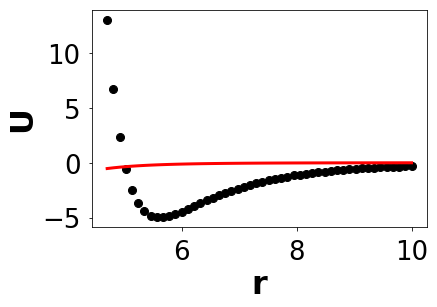

In [18]:
optimization = Optimization(ff, system, target, configurations=1, verbose=True)

starting_potential = np.array([optimization.forcefield.calc_potential(r) for r in separations])

plt.plot(separations, potential, linestyle='None', marker='o', color='black')
plt.plot(separations, starting_potential, marker='None', color='red')
plt.xlabel('r')
plt.ylabel('U')

We can provide a number of `configurations` to sample at each separation as an argument during instantiation of an `Optimization`.  Because our system contains only point particles, we set this value to 1.

In [19]:
optimization.driver()

##############################################
Setup: Checking root problem for potential issues...

No recorders have been specified, so no data will be saved.

Setup: Check of root problem complete.
##############################################

Current values:
sigma:	2.5
epsilon:	6.0
Residual:	0.9437446981841312

Current values:
sigma:	2.5
epsilon:	6.0
Residual:	0.9437446981841312

Current values:
sigma:	5.0
epsilon:	6.0
Residual:	0.09090909090909095

Current values:
sigma:	5.0
epsilon:	12.0
Residual:	0.41176470588235276

Current values:
sigma:	7.339881458378464
epsilon:	3.8872436435208098
Residual:	0.9935882718273331

Current values:
sigma:	6.169940729189232
epsilon:	4.943621821760405
Residual:	0.9207232080131129

Current values:
sigma:	4.383780573228684
epsilon:	5.7494485280804035
Residual:	0.37569546899296447

Current values:
sigma:	5.028625808162965
epsilon:	7.498425855188177
Residual:	0.2220761036735348

Current values:
sigma:	5.283400673670345
epsilon:	5.683961750700966
Resid

The optimization is launched by executing the `driver` function.

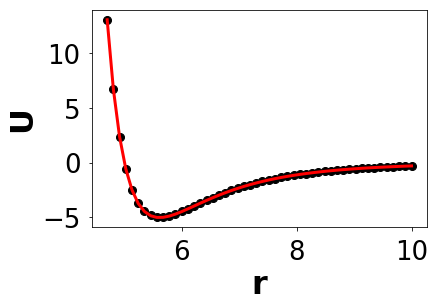

In [20]:
matched_potential = np.array([optimization.forcefield.calc_potential(r) for r in separations])

plt.plot(separations, potential, linestyle='None', marker='o', color='black')
plt.plot(separations, matched_potential, marker='None', color='red')
plt.xlabel('r')
plt.ylabel('U')

The plot above shows that the optimization did a pretty good job at recovering the `sigma` and `epsilon` values of our 12-6 LJ potential.  The `sigma` value was recovered nearly exactly, whereas the `epsilon` value is slightly larger than expected.  This demonstrates that the optimization scheme does a better job at locating potential wells, and is less accurate at reproducing the depths of these wells.